In [1]:
# rock_paper_scissors multi-classification model with CNN
# train : 2520 images [rock(840) + paper(840) + scissors(840)]  , size는 300*300
# validation : 372 images [rock(124) + paper(124) + scissors(124)] , size는 300*300

In [2]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

In [3]:
# Colab용 : Linux/GPU사용 
# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datasets/rps.zip \
#     -O /tmp/rps.zip

# !wget --no-check-certificate \
#     https://storage.googleapis.com/learning-datasets/rps-test-set.zip \
#     -O /tmp/rps-test-set.zip

In [4]:
# rps 데이터셋 다운로드 
# https://storage.googleapis.com/learning-datasets/rps.zip
# https://storage.googleapis.com/learning-datasets/rps-test-set.zip

_TRAIN_URL = "https://storage.googleapis.com/learning-datasets/rps.zip"
_TEST_URL = "https://storage.googleapis.com/learning-datasets/rps-test-set.zip"
urllib.request.urlretrieve(_TRAIN_URL, 'tmp/rps.zip')
urllib.request.urlretrieve(_TEST_URL, 'tmp/rps-test-set.zip')

('tmp/rps-test-set.zip', <http.client.HTTPMessage at 0x25d7769b9a0>)

In [5]:
# 압축해제
local_zip = 'tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

local_zip = 'tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('tmp/')
zip_ref.close()

In [6]:
# 이미지 데이터 경로 설정
import os

rock_dir = os.path.join('tmp/rps/rock')
paper_dir = os.path.join('tmp/rps/paper')
scissors_dir = os.path.join('tmp/rps/scissors')

rock_files = os.listdir(rock_dir)
print(rock_files[:10])

paper_files = os.listdir(paper_dir)
print(paper_files[:10])

scissors_files = os.listdir(scissors_dir)
print(scissors_files[:10])

print('total training rock images:', len(os.listdir(rock_dir)))
print('total training paper images:', len(os.listdir(paper_dir)))
print('total training scissors images:', len(os.listdir(scissors_dir)))


['rock01-000.png', 'rock01-001.png', 'rock01-002.png', 'rock01-003.png', 'rock01-004.png', 'rock01-005.png', 'rock01-006.png', 'rock01-007.png', 'rock01-008.png', 'rock01-009.png']
['paper01-000.png', 'paper01-001.png', 'paper01-002.png', 'paper01-003.png', 'paper01-004.png', 'paper01-005.png', 'paper01-006.png', 'paper01-007.png', 'paper01-008.png', 'paper01-009.png']
['scissors01-000.png', 'scissors01-001.png', 'scissors01-002.png', 'scissors01-003.png', 'scissors01-004.png', 'scissors01-005.png', 'scissors01-006.png', 'scissors01-007.png', 'scissors01-008.png', 'scissors01-009.png']
total training rock images: 840
total training paper images: 840
total training scissors images: 840


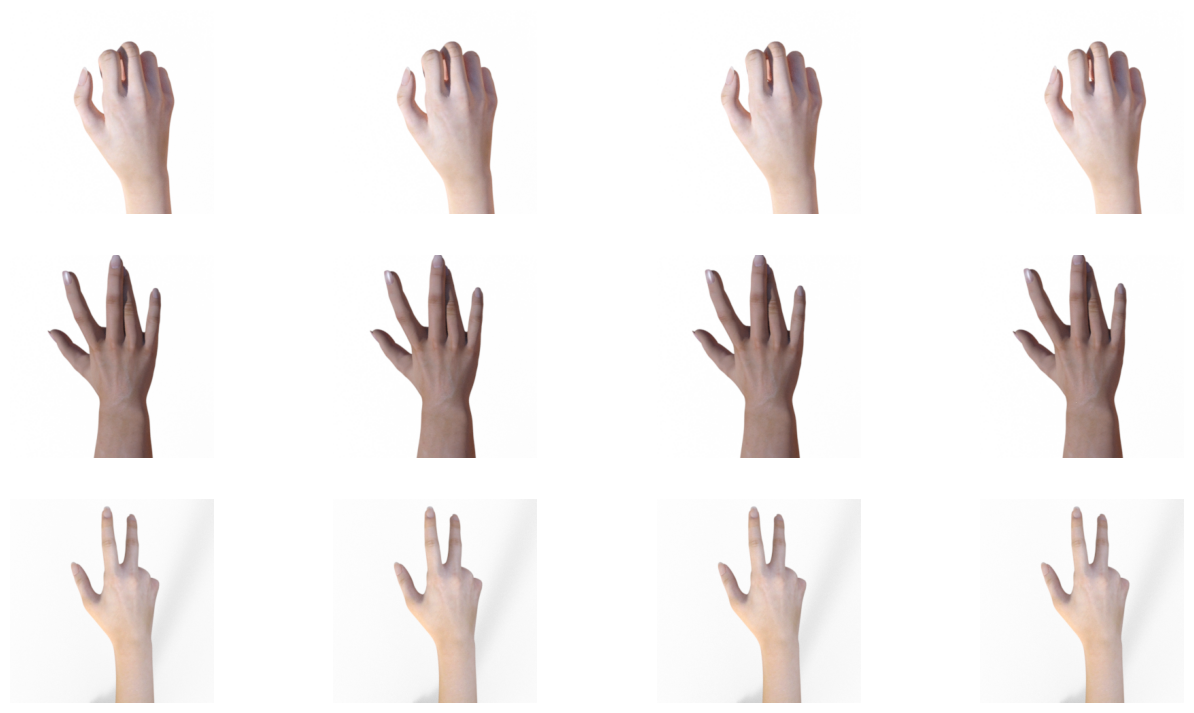

In [7]:
# 데이터 시각화
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 3
ncols = 4

pic_index = 4

# Set up matplotlib fig, and size it to fit 3x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols*4, nrows*3)

next_rock = [os.path.join(rock_dir, fname) 
                for fname in rock_files[pic_index-4:pic_index]]
next_paper = [os.path.join(paper_dir, fname) 
                for fname in paper_files[pic_index-4:pic_index]]
next_scissors = [os.path.join(scissors_dir, fname) 
                for fname in scissors_files[pic_index-4:pic_index]]

for i, img_path in enumerate(next_rock+next_paper+next_scissors):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)

    img = mpimg.imread(img_path)
    plt.imshow(img)

plt.show()    

### 학습모델 구현

In [8]:
TRAINING_DIR = "tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,
      rotation_range=40,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

VALIDATION_DIR = "tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255)

train_generator = training_datagen.flow_from_directory(
    TRAINING_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
    VALIDATION_DIR,
    target_size=(150,150),
    class_mode='categorical',
    batch_size=126
)

model = tf.keras.models.Sequential([
    # Note the input shape is the desired size of the image 150x150 with 3 bytes color
    # This is the first convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu', input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),
    # The second convolution
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The third convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # The fourth convolution
    tf.keras.layers.Conv2D(128, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),
    # Flatten the results to feed into a DNN
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dropout(0.5),
    # 512 neuron hidden layer
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(3, activation='softmax')
])

model.compile(loss = 'categorical_crossentropy', 
              optimizer='rmsprop', 
              metrics=['accuracy'])

model.summary()

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        36928     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                       

In [9]:
# 학습
# GPU   : 약 5분 소요 
history = model.fit(train_generator,
                    epochs=25, 
                    steps_per_epoch=20,   # 2520/126
                    validation_data = validation_generator, 
                    validation_steps=3,   # 372/126
                    verbose = 1) 

Epoch 1/25
20/20 [==============================] - 15s 556ms/step - loss: 1.6682 - accuracy: 0.3615 - val_loss: 1.0840 - val_accuracy: 0.3441
Epoch 2/25
20/20 [==============================] - 10s 517ms/step - loss: 1.0891 - accuracy: 0.4091 - val_loss: 1.2480 - val_accuracy: 0.4086
Epoch 3/25
20/20 [==============================] - 11s 523ms/step - loss: 1.1574 - accuracy: 0.4448 - val_loss: 0.8673 - val_accuracy: 0.5726
Epoch 4/25
20/20 [==============================] - 11s 524ms/step - loss: 1.0060 - accuracy: 0.5599 - val_loss: 0.8110 - val_accuracy: 0.5054
Epoch 5/25
20/20 [==============================] - 11s 533ms/step - loss: 0.8564 - accuracy: 0.6163 - val_loss: 0.9047 - val_accuracy: 0.7661
Epoch 6/25
20/20 [==============================] - 11s 526ms/step - loss: 0.6991 - accuracy: 0.6889 - val_loss: 0.2335 - val_accuracy: 0.9785
Epoch 7/25
20/20 [==============================] - 10s 520ms/step - loss: 0.6436 - accuracy: 0.7187 - val_loss: 0.4030 - val_accuracy: 0.7419

### 학습 결과 시각화

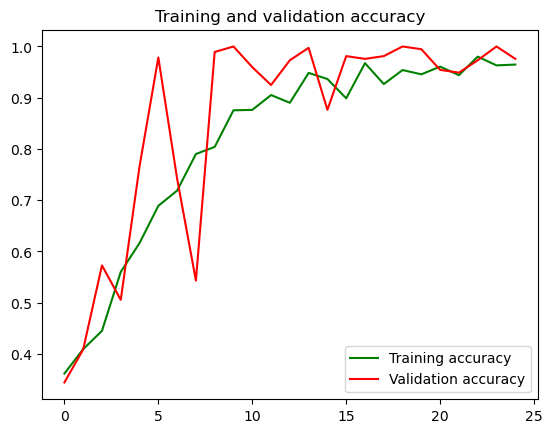

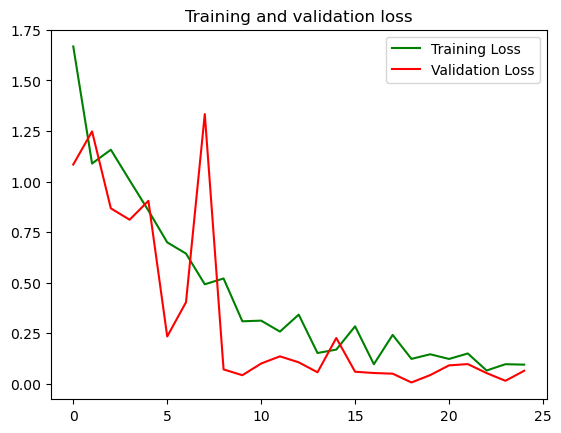

In [10]:
#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
acc      = history.history[     'accuracy' ]
val_acc  = history.history[ 'val_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot(epochs, acc, 'g', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot(epochs, loss, 'g', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [11]:
model.save("rps.h5")

In [12]:
# 정확도가 높다